In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
from sklearn.cluster import KMeans

startRampPath = 'data/BLM/start_ramp'

In [3]:
def getRowWithBlmMax(blmData):
    """
    Parameters
        blmData : DataFrame -- DataFrame loaded from the BLM data file, without timestamp column
    Returns
        DataFrame with row with the max BLM value in the provided data
    """
    maxes = blmData.max(axis=1)  # row index -> max for that row
    maxOverallIdx = maxes.idxmax() # row index where max overall in blmData can be found
    
    return blmData.loc[maxOverallIdx] # row containing max overall

In [4]:
files = sorted(os.listdir(startRampPath))
files = [file for file in files if file.endswith('.txt')] # keep only text files - filter out files such as desktop.ini

# To confirm that fills have been loaded in chronological order
files

['Fill_6925_start_ramp.txt',
 'Fill_6927_start_ramp.txt',
 'Fill_6928_start_ramp.txt',
 'Fill_6929_start_ramp.txt',
 'Fill_6931_start_ramp.txt',
 'Fill_6938_start_ramp.txt',
 'Fill_6939_start_ramp.txt',
 'Fill_6940_start_ramp.txt',
 'Fill_6942_start_ramp.txt',
 'Fill_6944_start_ramp.txt',
 'Fill_6946_start_ramp.txt',
 'Fill_6952_start_ramp.txt',
 'Fill_6953_start_ramp.txt',
 'Fill_6956_start_ramp.txt',
 'Fill_6957_start_ramp.txt',
 'Fill_6960_start_ramp.txt',
 'Fill_6961_start_ramp.txt',
 'Fill_6962_start_ramp.txt',
 'Fill_6963_start_ramp.txt',
 'Fill_6964_start_ramp.txt',
 'Fill_6966_start_ramp.txt',
 'Fill_6967_start_ramp.txt',
 'Fill_6972_start_ramp.txt',
 'Fill_6973_start_ramp.txt',
 'Fill_6974_start_ramp.txt',
 'Fill_6975_start_ramp.txt',
 'Fill_6976_start_ramp.txt',
 'Fill_6978_start_ramp.txt',
 'Fill_6979_start_ramp.txt',
 'Fill_6980_start_ramp.txt',
 'Fill_6981_start_ramp.txt',
 'Fill_6984_start_ramp.txt',
 'Fill_6988_start_ramp.txt',
 'Fill_6989_start_ramp.txt',
 'Fill_6990_st

In [5]:
rowsToCluster = pd.DataFrame()
maxFiles = 5

for i, file in enumerate(files):
    if i >= maxFiles:
        break
    
    # load BLM data file as a DataFrame
    blmData = pd.read_csv(startRampPath + '/' + file, sep=' ', header=None)
    
    # Delete first column (contains timestamps)
    blmData = blmData.drop(columns=0)
    
    rowsToCluster = rowsToCluster.append(getRowWithBlmMax(blmData), ignore_index=True)

In [6]:
kmeans = KMeans(n_clusters = 2)
kmeans.fit(rowsToCluster)
print("Cluster memberships:\n{}".format(kmeans.labels_))

Cluster memberships:
[1 1 0 1 1]


In [34]:
blmLabels = np.genfromtxt('data/blm_labels.txt', dtype='str')
beam1BlmLabels = np.genfromtxt('data/beam1_blm_labels.txt', dtype='str')
beam2BlmLabels = np.genfromtxt('data/beam2_blm_labels.txt', dtype='str')
logicalBlmLabels = np.genfromtxt('data/logical_blm_labels.txt', dtype='str')

rowsToCluster.columns = blmLabels

# Extract out of rowsToCluster BLMs associated with beam 1, and BLMs associated with Beam 2
beam1BlmData = rowsToCluster.filter(items=beam1BlmLabels); 
beam2BlmData = rowsToCluster.filter(items=beam2BlmLabels);

beam1BlmData.columns = logicalBlmLabels  
beam2BlmData.columns = logicalBlmLabels

# merge BLM data associated with beam 1, and BLM data associated with beam 2, under the same logical BLM labels
mergedBlmData = pd.concat([beam1BlmData, beam2BlmData], keys=['B1', 'B2'])

In [35]:
kmeans = KMeans(n_clusters = 2)
kmeans.fit(mergedBlmData)
print("Cluster memberships:\n{}".format(kmeans.labels_))

Cluster memberships:
[0 0 0 0 0 0 1 0 0 1]


<IPython.core.display.Javascript object>


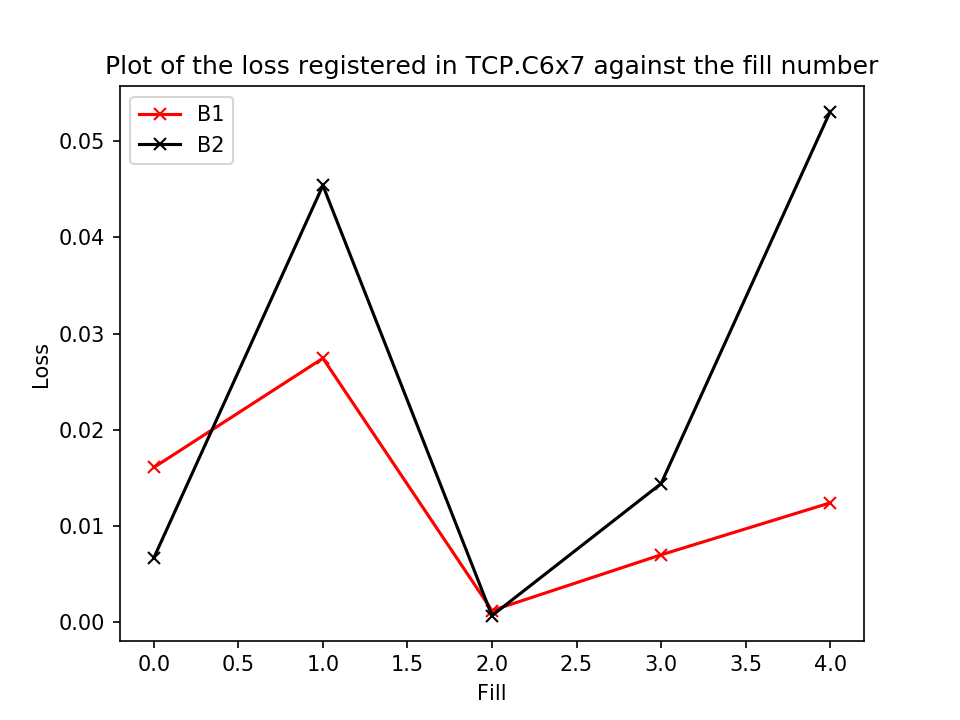

Text(0, 0.5, 'Loss')

In [36]:
# Data
df = pd.DataFrame({
    'B1': mergedBlmData.loc['B1']['TCP.C6x7'],
    'B2': mergedBlmData.loc['B2']['TCP.C6x7']
})
 
# multiple line plot
plt.figure()
plt.plot('B1', data=df, marker='x', color='red')
plt.plot('B2', data=df, marker='x', color='black')
plt.legend()
plt.title('Plot of the loss registered in TCP.C6x7 against the fill number')
plt.xlabel('Fill')
plt.ylabel('Loss')


In [39]:
plt.figure(figsize=(10, 36))
ncols = 3;
nrows = math.ceil(mergedBlmData.shape[1] / ncols)
i = 1;

for column in mergedBlmData:
    # Data
    df = pd.DataFrame({
        'B1': mergedBlmData.loc['B1'][column],
        'B2': mergedBlmData.loc['B2'][column]
    })
 
    plt.subplot(nrows, ncols, i)
    plt.yscale('log')
    plt.plot('B1', data=df, marker='x', color='red')
    plt.plot('B2', data=df, marker='x', color='black')
    plt.title(column)

    
    i = i + 1

plt.tight_layout()

<IPython.core.display.Javascript object>

ValueError: If using all scalar values, you must pass an index

In [40]:
#To get Euclidean distance between the BLM vectors for beam 1 and beam 2
from scipy.spatial.distance import cdist
from scipy.spatial.distance import euclidean

distance = cdist(mergedBlmData.loc['B1'].values, mergedBlmData.loc['B2'].values, metric='euclidean').diagonal()
#getting diagonal to get the euclidean distance of pairs of vectors we care about (i.e. corresponding rows)
#eg. euclidean distance between row 0 of B1 values, row 0 of B2 values; euclidean distance between row 1 of B1 values,
#row 1 of B2 values, and so on.

#to confirm values are correct:
print(distance)
print(euclidean(mergedBlmData.loc['B1'].iloc[0], mergedBlmData.loc['B2'].iloc[0]))
print(euclidean(mergedBlmData.loc['B1'].iloc[1], mergedBlmData.loc['B2'].iloc[1]))
print(euclidean(mergedBlmData.loc['B1'].iloc[2], mergedBlmData.loc['B2'].iloc[2]))


[0.01218755 0.02712671 0.00166997 0.01082156 0.06335923]
0.012187554725641404
0.027126712341282815
0.001669969753250794


<IPython.core.display.Javascript object>


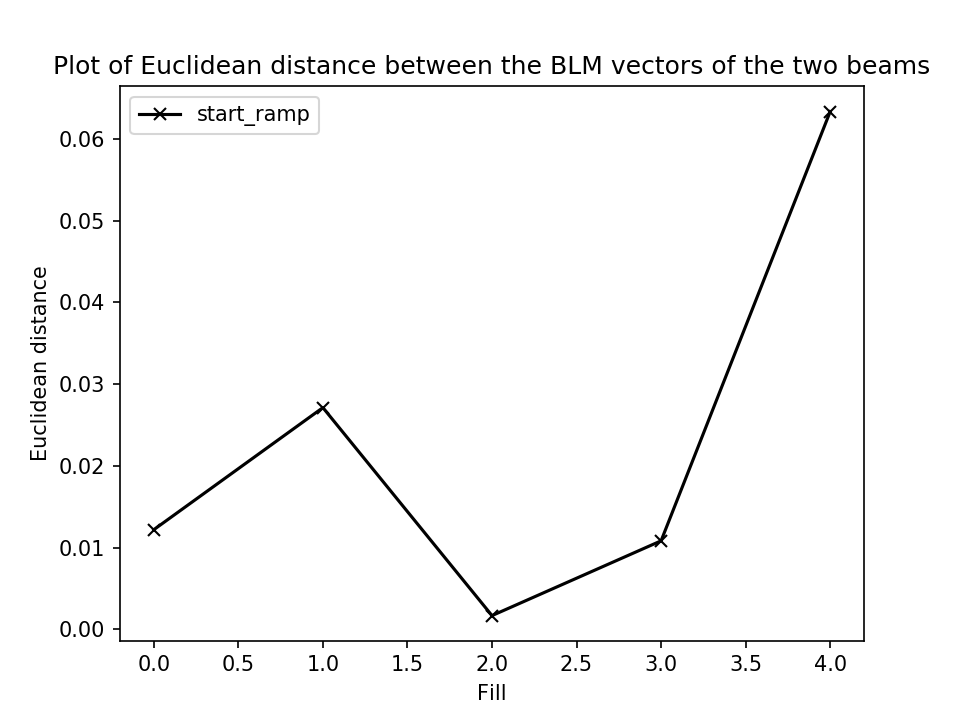

Text(0, 0.5, 'Euclidean distance')

In [41]:
# To plot Euclidean between the vectors (TCP, TCSG, ...) for beam 1 and beam 2
# Data
df = pd.DataFrame({
    'start_ramp': distance
})
 
# multiple line plot
plt.figure()
plt.plot('start_ramp', data=df, marker='x', color='black')
plt.legend()
plt.title('Plot of Euclidean distance between the BLM vectors of the two beams')
plt.xlabel('Fill')
plt.ylabel('Euclidean distance')